I want to create a CRNN testing utility

I have csv file containing two columns "file_name" and "digit". I have a folder called "digits" containing 200000 image files of images of digits.

I want to create the train and test datasets and crnn model

Can you provide the steps and code for this please

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import sys
sys.path.append("../project_functions/")
import ad_functions as adfns
import ad_crnn_functions as adcrn


import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, 
    Conv2D, 
    MaxPooling2D, 
    Reshape, 
    Bidirectional, 
    LSTM, 
    Dense, 
    BatchNormalization, 
    Dropout, 
    Softmax, 
    Flatten
)


## Load the Dataset

In [3]:
data = pd.read_csv('digit_training_data.csv')

In [4]:
# Load the dataset and split it into train and test sets
def load_images(file_names):
    images = []
    for file_name in file_names:
        # print(file_name)
        image = cv2.imread(os.path.join('./digits', file_name), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        image = np.expand_dims(image, axis=-1)
        images.append(image)
    return np.array(images)


In [5]:

X = load_images(data['file_name'].values)
y = data['digit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Normalize images


In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## One-hot encode labels


In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Define the CRNN model

In [8]:

# Create the model
def create_crnn_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Reshape for LSTM
    x = Reshape(target_shape=((8, 8*64)))(x)

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    # Dense layer for classification
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [7]:
# def create_crnn_model(
#     input_shape=(32, 32, 3), num_digits=5, num_classes=11, learning_rate=1e-4
# ):
#     input_layer = Input(shape=input_shape)

#     x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Flatten()(x)
#     x = Dense(512, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)

#     x = Dense(num_classes * num_digits, activation="linear")(x)
#     x = Reshape((num_digits, num_classes))(x)
#     x = Softmax(axis=-1)(x)

#     model = Model(inputs=input_layer, outputs=x)
#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss="categorical_crossentropy",
#         metrics=["accuracy"],
#     )

#     return model


In [9]:
input_shape = (32, 32, 1)
num_classes = 10

crnn_model = create_crnn_model(input_shape, num_classes)

## Train the CRNN model


In [10]:
crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 25

history = crnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/25
2500/2500 [==============================] - 36s 12ms/step - loss: 0.7402 - accuracy: 0.7232 - val_loss: 0.2628 - val_accuracy: 0.9060
Epoch 2/25
2500/2500 [==============================] - 29s 11ms/step - loss: 0.2035 - accuracy: 0.9268 - val_loss: 0.1445 - val_accuracy: 0.9482
Epoch 3/25
2500/2500 [==============================] - 28s 11ms/step - loss: 0.1445 - accuracy: 0.9482 - val_loss: 0.1652 - val_accuracy: 0.9400
Epoch 4/25
2500/2500 [==============================] - 28s 11ms/step - loss: 0.1180 - accuracy: 0.9578 - val_loss: 0.1458 - val_accuracy: 0.9481
Epoch 5/25
2500/2500 [==============================] - 28s 11ms/step - loss: 0.0942 - accuracy: 0.9660 - val_loss: 0.1070 - val_accuracy: 0.9631
Epoch 6/25
2500/2500 [==============================] - 28s 11ms/step - loss: 0.0828 - accuracy: 0.9704 - val_loss: 0.0967 - val_accuracy: 0.9645
Epoch 7/25
2500/2500 [==============================] - 29s 12ms/step - loss: 0.0709 - accuracy: 0.9747 - val_loss: 0.0686 -

In [12]:

# Test the CRNN model
score = crnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1250/1250 [==============================] - 8s 6ms/step - loss: 0.0326 - accuracy: 0.9892
Test loss: 0.03259269893169403
Test accuracy: 0.9891999959945679


## Analysis

Based on the output of the training, it seems that the CRNN model is performing well on the dataset. The training accuracy increases from 72.06% in the first epoch to 99.08% in the last epoch, while the validation accuracy increases from 88.73% to 98.77%. The loss function is also decreasing for both the training and validation sets, indicating that the model is learning to classify the images of digits correctly.

However, it is important to be cautious of overfitting, as the training accuracy is higher than the validation accuracy. Overfitting occurs when the model learns the training data too well, including the noise, which may hurt its performance on unseen data. One way to mitigate overfitting is to employ regularization techniques such as dropout or early stopping. You could also try reducing the model's complexity or increasing the size of the training dataset.

Overall, the CRNN model appears to be a good fit for this problem, as the validation accuracy is quite high at 98.77%.

## Save the Model

In [14]:
model_file = "CRNN_digits_model.h5"
crnn_model.save(model_file)

## Load the Model

In [ ]:
# from tensorflow.keras.models import load_model
model_file = "CRNN_digits_model.h5"
crnn_model = load_model(model_file)

In [14]:
# import sys
# sys.path.append("../project_functions/")
# import ad_functions as adfns

import ad_crnn_functions as adcrn


## Testing the Model against SIPA 09 Cropped

In [28]:
def preprocess_digit_gray(digit_image, target_size=(32, 32)):
    digit_image = cv2.resize(digit_image, target_size)
    digit_image = cv2.cvtColor(digit_image, cv2.COLOR_RGB2GRAY)
    digit_image = digit_image.astype("float32") / 255.0
    digit_image = np.expand_dims(digit_image, axis=-1)
    digit_image = np.expand_dims(digit_image, axis=0)
    return digit_image

(300, 1182)


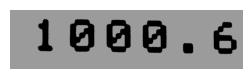

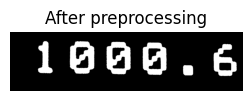

ValueError: in user code:

    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\USER\anaconda3\envs\py3-TF2\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_1" (type Functional).
    
    Input 0 of layer "conv2d_2" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 32, 32, 3)
    
    Call arguments received by layer "model_1" (type Functional):
      • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
      • training=False
      • mask=None


In [33]:
image_path = "./cropped_images/9/S09_F03_Cropped.png"

img = cv2.imread(image_path)
img = adfns.invert_thresh(img)
print(img.shape)
adfns.show_img(img, 3)


preprocess_image = adcrn.preprocess_image(img)

adfns.show_img(preprocess_image, 3, title="After preprocessing")

digit_images = adcrn.extract_digits(preprocess_image)
predictions = []

# preprocessed_digit_b = preprocess_digit_gray(digit_images[0])
preprocessed_digit_a = adcrn.preprocess_digit(digit_images[0])

prediction = crnn_model.predict(preprocessed_digit_a)


In [26]:
print(preprocessed_digit.shape)

(1, 32, 32, 3)


(247, 726)


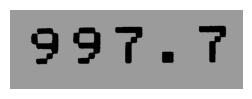

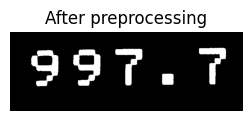

1/1 [==============================] - 0s 17ms/step
Predicted number: 44676
[4, 4, 6, 7, 6]


In [17]:
image_path = "./cropped_images/9/S09_F01_Cropped.png"

img = cv2.imread(image_path)
img = adfns.invert_thresh(img)
print(img.shape)
adfns.show_img(img, 3)

preprocess_image = adcrn.preprocess_image(img)

adfns.show_img(preprocess_image, 3, title="After preprocessing")

digit_images = adcrn.extract_digits(preprocess_image)
predictions = []

for digit_image in digit_images:
    preprocessed_digit = adcrn.preprocess_digit(digit_image)
    prediction = crnn_model.predict(preprocessed_digit)
    digit_prediction = np.argmax(prediction)
    # print("Predicted digit:", digit_prediction)
    predictions.append(digit_prediction)

print("Predicted number:", ''.join(map(str, predictions)))
print(predictions)

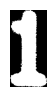

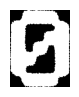

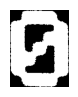

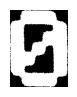

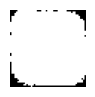

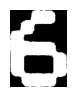

In [17]:
for digit_image in digit_images:
    adfns.show_img(digit_image, 1)

In [20]:
def ad_process_and_predict_digits(crnn_model, directory_path):
    file_list = os.listdir(directory_path)

    for file_name in file_list:
        image_path = os.path.join(directory_path, file_name)
        img = cv2.imread(image_path)
        img = adfns.invert_thresh(img)
        print(img.shape)
        adfns.show_img(img, 3)

        preprocess_image = adcrn.preprocess_image(img)

        adfns.show_img(preprocess_image, 3, title="After preprocessing")

        digit_images = adcrn.extract_digits(preprocess_image)
        predictions = []

        for digit_image in digit_images:
            preprocessed_digit = adcrn.preprocess_digit(digit_image)
            prediction = crnn_model.predict(preprocessed_digit)
            digit_prediction = np.argmax(prediction)
            predictions.append(digit_prediction)

        print("Predicted number:", "".join(map(str, predictions)))
        print(predictions)


(247, 726)


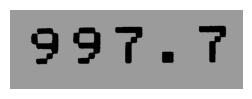

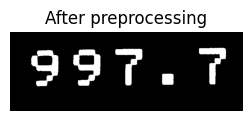

1/1 [==============================] - 0s 15ms/step
Predicted number: 44676
[4, 4, 6, 7, 6]
(275, 696)


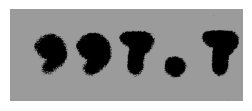

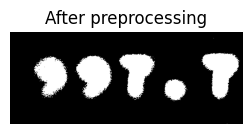

1/1 [==============================] - 0s 18ms/step
Predicted number: 88030
[8, 8, 0, 3, 0]
(300, 1182)


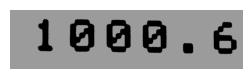

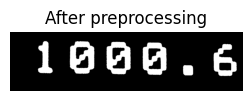

1/1 [==============================] - 0s 15ms/step
Predicted number: 888875
[8, 8, 8, 8, 7, 5]
(484, 1236)


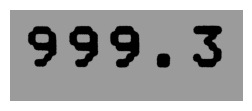

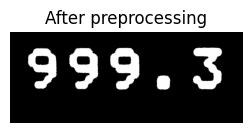

1/1 [==============================] - 0s 18ms/step
Predicted number: 99549
[9, 9, 5, 4, 9]
(272, 844)


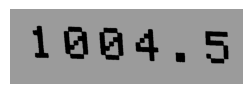

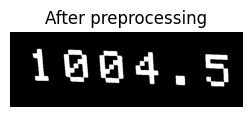

1/1 [==============================] - 0s 19ms/step
Predicted number: 0884758
[0, 8, 8, 4, 7, 5, 8]
(223, 761)


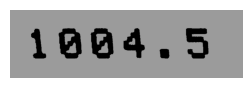

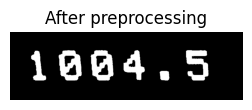

1/1 [==============================] - 0s 16ms/step
Predicted number: 888078
[8, 8, 8, 0, 7, 8]
(178, 586)


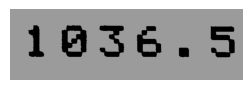

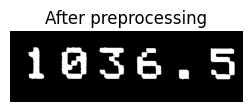

1/1 [==============================] - 0s 16ms/step
Predicted number: 833873
[8, 3, 3, 8, 7, 3]
(285, 1081)


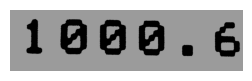

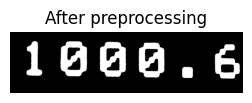

1/1 [==============================] - 0s 24ms/step
Predicted number: 888875
[8, 8, 8, 8, 7, 5]
(273, 709)


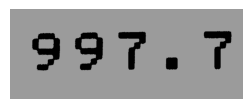

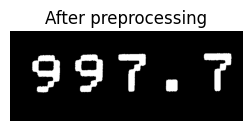

1/1 [==============================] - 0s 17ms/step
Predicted number: 94686
[9, 4, 6, 8, 6]
(202, 594)


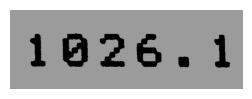

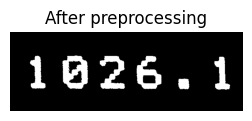

1/1 [==============================] - 0s 17ms/step
Predicted number: 887878
[8, 8, 7, 8, 7, 8]
(162, 628)


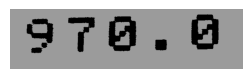

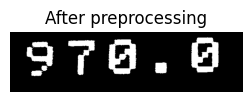

1/1 [==============================] - 0s 15ms/step
Predicted number: 5487078
[5, 4, 8, 7, 0, 7, 8]
(200, 614)


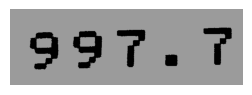

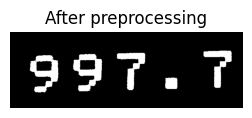

1/1 [==============================] - 0s 16ms/step
Predicted number: 49616
[4, 9, 6, 1, 6]
(227, 775)


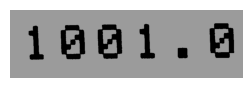

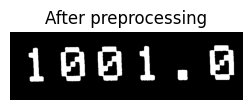

1/1 [==============================] - 0s 18ms/step
Predicted number: 888873
[8, 8, 8, 8, 7, 3]
(333, 793)


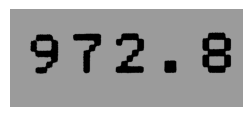

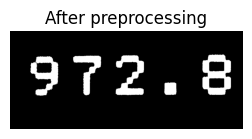

1/1 [==============================] - 0s 17ms/step
Predicted number: 46738
[4, 6, 7, 3, 8]
(182, 623)


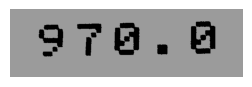

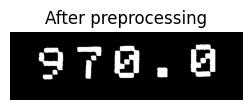

1/1 [==============================] - 0s 14ms/step
Predicted number: 578448813
[5, 7, 8, 4, 4, 8, 8, 1, 3]
(214, 674)


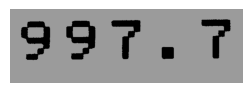

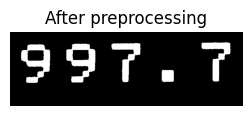

1/1 [==============================] - 0s 15ms/step
Predicted number: 44676
[4, 4, 6, 7, 6]
(192, 535)


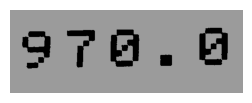

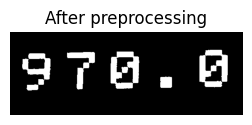

1/1 [==============================] - 0s 16ms/step
Predicted number: 5817333
[5, 8, 1, 7, 3, 3, 3]
(211, 694)


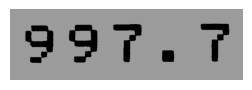

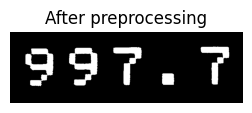

1/1 [==============================] - 0s 15ms/step
Predicted number: 44676
[4, 4, 6, 7, 6]
(211, 601)


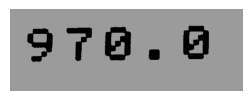

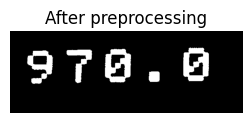

1/1 [==============================] - 0s 15ms/step
Predicted number: 97885
[9, 7, 8, 8, 5]
(184, 589)


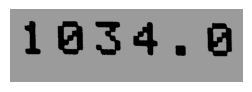

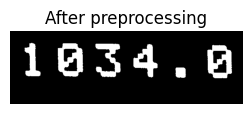

1/1 [==============================] - 0s 18ms/step
Predicted number: 803178
[8, 0, 3, 1, 7, 8]


In [21]:
ad_process_and_predict_digits(crnn_model, "./cropped_images/9/")